In [1]:
import pandas as pd

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# verify production target is almost 0 in winter

In [4]:
train = pd.read_csv("../data/train.csv")

<Axes: >

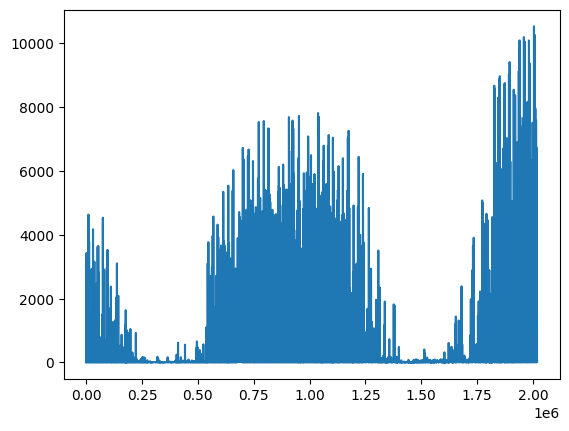

In [11]:
train.loc[(train.is_consumption==0)&(train.prediction_unit_id==5)].target.plot()

<Axes: xlabel='datetime'>

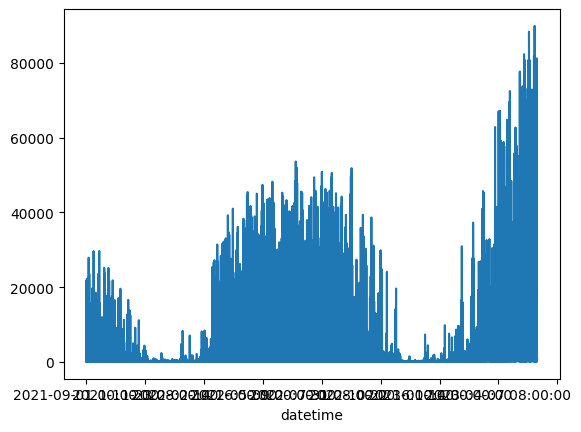

In [17]:
train.loc[train.is_consumption == 0].groupby(['datetime'])['target'].sum().plot()

# load data


In [3]:
client = pd.read_csv("../data/client.csv")
ePrices = pd.read_csv("../data/electricity_prices.csv")
gasPrices = pd.read_csv("../data/gas_prices.csv")

weatherPredInt = pd.read_csv("interpolPredWeather.csv")
#weatherHist = pd.read_csv("../data/historical_weather.csv")
train = pd.read_csv("../data/train.csv")

## combine data

In [4]:
producing = train.loc[train.is_consumption == 0]
consuming = train.loc[train.is_consumption == 1]
train = pd.merge(producing.drop('is_consumption',axis = 1), consuming.drop('is_consumption',axis = 1),on=['data_block_id','prediction_unit_id','datetime','county','is_business','product_type'], how='outer',suffixes=('_prod', '_cons'))
del producing, consuming
print(train.shape)

(1009176, 10)


In [130]:
df_prices = pd.merge(ePrices, gasPrices[['data_block_id','lowest_price_per_mwh','highest_price_per_mwh']], on=['data_block_id'], how='outer',suffixes=('_el', '_gas'))

In [138]:
df_prices['datetime'] = pd.to_datetime(df_prices['forecast_date'])
df_prices['hour'] = pd.to_datetime(df_prices['forecast_date']).dt.hour
train['datetime'] = pd.to_datetime(train['datetime'])
train['hour'] = pd.to_datetime(train['datetime']).dt.hour

In [142]:
df = pd.merge(train, df_prices,on=['data_block_id','hour'], how='outer',suffixes=('', '_GasEl_prices'))
del df_prices

In [143]:
weatherPredInt['datetime'] = pd.to_datetime(weatherPredInt['forecast_datetime'])
weatherPredInt = weatherPredInt.rename(columns={'County': 'county'})

In [144]:
weatherPredInt['hour'] = weatherPredInt['datetime'].dt.hour

In [145]:
df = pd.merge(df, weatherPredInt, on=['hour','county','data_block_id'], how='inner')
df.shape

(1007712, 36)

In [169]:
client

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2
...,...,...,...,...,...,...,...
41914,1,15,51,415.60,0,2023-05-29,637
41915,3,15,161,2035.75,0,2023-05-29,637
41916,0,15,15,620.00,1,2023-05-29,637
41917,1,15,20,624.50,1,2023-05-29,637


In [146]:
# merge with clients
df = pd.merge(df, client, on=['county','is_business','product_type','data_block_id'], how='outer')
df.shape

(1007762, 39)

In [147]:
df['yearday'] = df['datetime_x'].dt.day_of_year
df['weekday'] = df['datetime_x'].dt.day_of_week
df['month'] = df['datetime_x'].dt.month

In [148]:
df = df.dropna()

# check correlations

### investigate on relative production (targets / capacity)
- relative Production is NOT const over all customers in county -> something else needs to be there
-  investigate product type, business & installed capacity
- usually only around 6 customers per county, mostly less

In [153]:
df['relProd'] = df['target_prod'] / df['installed_capacity']
df['relProd_solarNorm'] = df['relProd'] / (df['product_type']+1)


In [53]:
#df.loc[(df.county == 0) & (df.data_block_id == 3)].groupby('datetime_x')['relProd'].mean()

In [54]:
#df.loc[(df.county == 0) & (df.data_block_id == 3)].groupby('datetime_x')['relProd'].std()
# we have a correlation but only 3 customers in there

In [55]:
# how many customers per county: max around 6
#df.loc[(df.datetime_x == '2021-09-04 11:00:00')].county.value_counts()

In [52]:
pd.set_option('Display.max_column', None)
df.loc[(df.county == 0) & (df.data_block_id == 3) & (df.datetime_x == '2021-09-04 16:00:00')]
# relative Production is NOT const over all customers in county -> something else needs to be there
# investigate product type, business & installed capacity

,county,is_business,product_type,target_prod,datetime_x,data_block_id,row_id_prod,prediction_unit_id,target_cons,row_id_cons,forecast_date,euros_per_mwh,origin_date,data_block_id_GasEl_prices,lowest_price_per_mwh,highest_price_per_mwh,hour,Unnamed: 0,latitude,longitude,forecast_datetime,hours_ahead,origin_datetime,temperatureint,dewpointint,cloudcover_highint,cloudcover_lowint,cloudcover_midint,cloudcover_totalint,10_metre_u_wind_componentint,10_metre_v_wind_componentint,direct_solar_radiationint,surface_solar_radiation_downwardsint,snowfallint,total_precipitationint,datetime_y,eic_count,installed_capacity,date,yearday,weekday,month,relProd,relProd_solarNorm
2944,0,0,1,251.643,2021-09-04 16:00:00,3,10736.0,0.0,52.525,10737.0,2021-09-04 16:00:00,89.27,2021-09-03 16:00:00,4.0,46.3,46.8,16.0,0.0,59.310926,24.924348,2021-09-04 16:00:00+00:00,40.0,2021-09-03 00:00:00+00:00,11.026382,1.945055,0.0,0.237879,0.33392,0.372942,1.458484,-3.092217,308.09048,119.079122,0.0,6.652520e-07,2021-09-04 16:00:00+00:00,108.0,952.89,2021-09-02,247.0,5.0,9.0,0.264084,0.132042
2968,0,0,2,58.577,2021-09-04 16:00:00,3,10738.0,1.0,9.580,10739.0,2021-09-04 16:00:00,89.27,2021-09-03 16:00:00,4.0,46.3,46.8,16.0,0.0,59.310926,24.924348,2021-09-04 16:00:00+00:00,40.0,2021-09-03 00:00:00+00:00,11.026382,1.945055,0.0,0.237879,0.33392,0.372942,1.458484,-3.092217,308.09048,119.079122,0.0,6.652520e-07,2021-09-04 16:00:00+00:00,17.0,166.40,2021-09-02,247.0,5.0,9.0,0.352025,0.117342
2992,0,0,3,1993.963,2021-09-04 16:00:00,3,10740.0,2.0,308.340,10741.0,2021-09-04 16:00:00,89.27,2021-09-03 16:00:00,4.0,46.3,46.8,16.0,0.0,59.310926,24.924348,2021-09-04 16:00:00+00:00,40.0,2021-09-03 00:00:00+00:00,11.026382,1.945055,0.0,0.237879,0.33392,0.372942,1.458484,-3.092217,308.09048,119.079122,0.0,6.652520e-07,2021-09-04 16:00:00+00:00,688.0,7207.88,2021-09-02,247.0,5.0,9.0,0.276637,0.069159
3016,0,1,0,131.600,2021-09-04 16:00:00,3,10742.0,3.0,5.600,10743.0,2021-09-04 16:00:00,89.27,2021-09-03 16:00:00,4.0,46.3,46.8,16.0,0.0,59.310926,24.924348,2021-09-04 16:00:00+00:00,40.0,2021-09-03 00:00:00+00:00,11.026382,1.945055,0.0,0.237879,0.33392,0.372942,1.458484,-3.092217,308.09048,119.079122,0.0,6.652520e-07,2021-09-04 16:00:00+00:00,5.0,400.00,2021-09-02,247.0,5.0,9.0,0.329000,0.329000
3040,0,1,1,179.423,2021-09-04 16:00:00,3,10744.0,4.0,334.786,10745.0,2021-09-04 16:00:00,89.27,2021-09-03 16:00:00,4.0,46.3,46.8,16.0,0.0,59.310926,24.924348,2021-09-04 16:00:00+00:00,40.0,2021-09-03 00:00:00+00:00,11.026382,1.945055,0.0,0.237879,0.33392,0.372942,1.458484,-3.092217,308.09048,119.079122,0.0,6.652520e-07,2021-09-04 16:00:00+00:00,43.0,1411.00,2021-09-02,247.0,5.0,9.0,0.127160,0.063580
3064,0,1,3,2200.999,2021-09-04 16:00:00,3,10746.0,5.0,3536.446,10747.0,2021-09-04 16:00:00,89.27,2021-09-03 16:00:00,4.0,46.3,46.8,16.0,0.0,59.310926,24.924348,2021-09-04 16:00:00+00:00,40.0,2021-09-03 00:00:00+00:00,11.026382,1.945055,0.0,0.237879,0.33392,0.372942,1.458484,-3.092217,308.09048,119.079122,0.0,6.652520e-07,2021-09-04 16:00:00+00:00,265.0,13417.79,2021-09-02,247.0,5.0,9.0,0.164036,0.041009


### investigate product type 
- we only have 1 "is_business", "product_type" pair per county!!! 
- this means our we have 1 individual customer per "county, is_business, product_type"
- is the chance to map production result to solar power per county
- not always customers for all business_product_types -> can't predict for all the customers at the same time

In [154]:
unique_pairs = list(set(zip(df['is_business'], df[ 'product_type'])))
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs)}
df['business_prodType'] = list(map(pair_index_dict.get, zip(df['is_business'], df['product_type'])))
unique_pairs

[(0, 1), (1, 2), (1, 1), (0, 3), (0, 2), (1, 0), (1, 3)]

In [125]:
#df.groupby('product_type')['installed_capacity'].max()

In [126]:
#df.groupby('product_type')['installed_capacity'].min()

In [127]:
#df.loc[(df.datetime_x == '2021-09-04 16:00:00')].groupby('business_prodType')[['relProd','relProd_solarNorm','installed_capacity','target_prod','target_cons']].mean()

In [129]:
#df.loc[(df.datetime_x == '2021-09-04 16:00:00')].groupby('business_prodType')[['relProd','relProd_solarNorm','installed_capacity','target_prod','target_cons']].std()

In [167]:
f = ['county', 'is_business', 'product_type', 'target_prod', 'target_cons',
       # 'euros_per_mwh', 'lowest_price_per_mwh',
       #'highest_price_per_mwh', 'hour', 'temperatureint',
       #'dewpointint', 'cloudcover_highint', 'cloudcover_lowint',
       #'cloudcover_midint', 'cloudcover_totalint',
       #'10_metre_u_wind_componentint', '10_metre_v_wind_componentint',
       #'direct_solar_radiationint', 'surface_solar_radiation_downwardsint',
       #'snowfallint', 'total_precipitationint', 'yearday', 'weekday', 'month',
        'eic_count',
       'installed_capacity', 'relProd',
       'relProd_solarNorm', 'business_prodType'
]
df.loc[(df.datetime_x == '2021-09-04 17:00:00') & (df.business_prodType == 0)][f]

,county,is_business,product_type,target_prod,target_cons,eic_count,installed_capacity,relProd,relProd_solarNorm,business_prodType
2945,0,0,1,152.195,63.018,108.0,952.89,0.159719,0.079860,0
3089,1,0,1,8.305,1.989,7.0,80.00,0.103813,0.051906,0
3209,3,0,1,21.140,10.372,16.0,179.90,0.117510,0.058755,0
3305,4,0,1,9.387,3.851,9.0,72.20,0.130014,0.065007,0
3401,5,0,1,24.113,18.810,24.0,289.80,0.083206,0.041603,0
3545,7,0,1,50.964,13.518,31.0,334.80,0.152222,0.076111,0
3689,8,0,1,13.637,11.741,11.0,83.00,0.164301,0.082151,0
3761,9,0,1,37.883,14.505,20.0,247.90,0.152816,0.076408,0
3857,10,0,1,38.577,9.042,19.0,240.70,0.160270,0.080135,0
3977,11,0,1,35.491,17.083,39.0,384.30,0.092352,0.046176,0


In [163]:
a = df.groupby(['datetime_x','county'])['business_prodType'].value_counts()
(a>1).any()

False

### investigate eic_count
- one eic count per customer, BUT different customer can have a same eic count
- individual customer = unique business_prodType per county

- a change indicates that we have a new customer with the old customer_id!
    - but how does this make sense if we don't have older data for predicting stuff??

In [170]:
a = df.groupby(['datetime_x','business_prodType'])['eic_count'].value_counts()
(a>1).any()
# whaat eic count is a multiple thing per county (each county has only 1 business_prod_type)

True

In [186]:
unique_pairs_cust = list(set(zip(df['is_business'], df[ 'product_type'], df['county'])))
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs_cust)}
df['customer_id'] = list(map(pair_index_dict.get, zip(df['is_business'], df['product_type'], df['county'])))
#unique_pairs_cust

<Axes: >

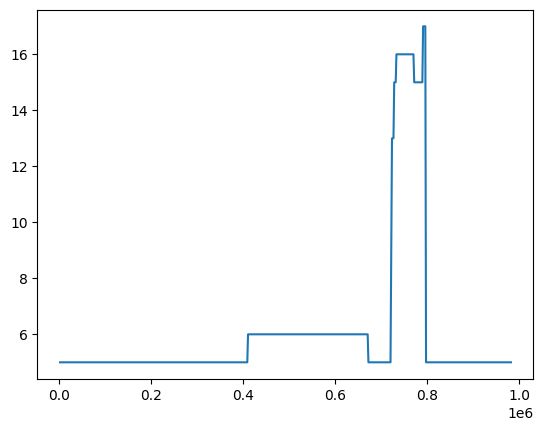

In [199]:
df.loc[df.customer_id == 38]['eic_count'].plot()

In [198]:
f2 = ['county', 'is_business', 'product_type', 'target_prod', 'target_cons',
       # 'euros_per_mwh', 'lowest_price_per_mwh',
       #'highest_price_per_mwh', 'hour', 'temperatureint',
       #'dewpointint', 'cloudcover_highint', 'cloudcover_lowint',
       #'cloudcover_midint', 'cloudcover_totalint',
       #'10_metre_u_wind_componentint', '10_metre_v_wind_componentint',
       #'direct_solar_radiationint', 'surface_solar_radiation_downwardsint',
       #'snowfallint', 'total_precipitationint', 'yearday', 'weekday', 'month',
        'eic_count',
       'installed_capacity', 'relProd',
       'relProd_solarNorm', 'business_prodType', 'customer_id'
]
df.loc[(df.datetime_x == '2021-09-04 16:00:00') & (df.eic_count == 5)][f2]#.eic_count.value_counts()

,county,is_business,product_type,target_prod,target_cons,eic_count,installed_capacity,relProd,relProd_solarNorm,business_prodType,customer_id
3016,0,1,0,131.600,5.600,5.0,400.0,0.329000,0.329000,5,44
3448,5,1,0,33.420,667.430,5.0,1160.0,0.028810,0.028810,5,68
3568,7,0,2,22.517,0.514,5.0,50.5,0.445881,0.148627,4,19
3928,10,1,2,16.915,46.581,5.0,121.5,0.139218,0.046406,1,38


In [202]:
b = df.groupby('customer_id').datetime_x.value_counts()
(b>1).any()

False

### individual customer id
- installed capacity is NOT constant for a customer -> changes over time OR we also have different customers by capacity!

In [220]:
unique_pairs_cust = list(set(zip(df['is_business'], df[ 'product_type'], df['county'], df['eic_count'],df['installed_capacity'])))
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs_cust)}
df['ind_customer_id'] = list(map(pair_index_dict.get, zip(df['is_business'], df['product_type'], df['county'], df['eic_count'],df['installed_capacity'])))

In [221]:
c = df.groupby(['datetime_x','ind_customer_id'])['installed_capacity'].value_counts()
(c>1).any()

False

<Axes: >

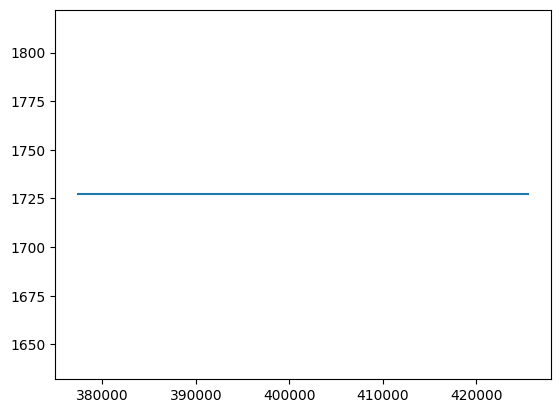

In [222]:
df.loc[df.ind_customer_id == 1]['installed_capacity'].plot()

### investigate consumption

In [174]:
df['relCons_ePrice'] = df['target_cons'] / df['euros_per_mwh']
df['relCons_prod'] = df['target_cons'] / df['target_prod']
df['relCons_eic'] = df['target_cons'] / df['eic_count']
df['relCons_cap'] = df['target_cons'] / df['installed_capacity']


In [204]:
f = ['county', #'is_business', 'product_type', 
       'target_prod', 'target_cons',
       # 'euros_per_mwh', 'lowest_price_per_mwh','highest_price_per_mwh',
       # 'hour', 
       'temperatureint',
       #'dewpointint', 'cloudcover_highint', 'cloudcover_lowint',
       #'cloudcover_midint', 'cloudcover_totalint',
       '10_metre_u_wind_componentint', '10_metre_v_wind_componentint',
       #'direct_solar_radiationint', 'surface_solar_radiation_downwardsint',
       'snowfallint', 'total_precipitationint', 
       # 'yearday', 'weekday', 'month',
        'eic_count',
       'installed_capacity', 'relProd',
       #'relProd_solarNorm', 
       'business_prodType',
       'relCons_ePrice','relCons_prod','relCons_eic','relCons_cap'
]
df.loc[(df.datetime_x == '2021-09-04 16:00:00') & (df.customer_id == 2)][f]

,county,target_prod,target_cons,temperatureint,10_metre_u_wind_componentint,10_metre_v_wind_componentint,snowfallint,total_precipitationint,eic_count,installed_capacity,relProd,business_prodType,relCons_ePrice,relCons_prod,relCons_eic,relCons_cap
2944,0,251.643,52.525,11.026382,1.458484,-3.092217,0.0,6.652520e-07,108.0,952.89,0.264084,0,0.568945,0.208728,0.486343,0.055122


### correlations
- what consumption exactly, electricity?
- is produced electricity directly used or is always produced and consumed absolute?

In [36]:
#df.loc[df.is_business == 0].target_prod.plot()

In [223]:
corr_matrix = df.drop(['datetime_x','origin_date','forecast_date','origin_datetime','datetime_y','date','Unnamed: 0','forecast_datetime'],axis=1).corr()
correlations_prod = corr_matrix['target_prod'].sort_values(ascending=False)
correlations_cons = corr_matrix['target_cons'].sort_values(ascending=False)

In [224]:
corr_matrix['target_cons'].sort_values()

prediction_unit_id                     -0.140789
county                                 -0.132839
relProd_solarNorm                      -0.100975
relProd                                -0.092634
customer_id                            -0.084177
temperatureint                         -0.074068
dewpointint                            -0.060886
direct_solar_radiationint              -0.047819
surface_solar_radiation_downwardsint   -0.047335
weekday                                -0.039559
lowest_price_per_mwh                   -0.026161
highest_price_per_mwh                  -0.023119
10_metre_u_wind_componentint           -0.016786
yearday                                -0.016208
month                                  -0.015955
longitude                              -0.003873
total_precipitationint                  0.005155
ind_customer_id                         0.008156
hours_ahead                             0.013658
hour                                    0.013658
10_metre_v_wind_comp

<AxesSubplot:>

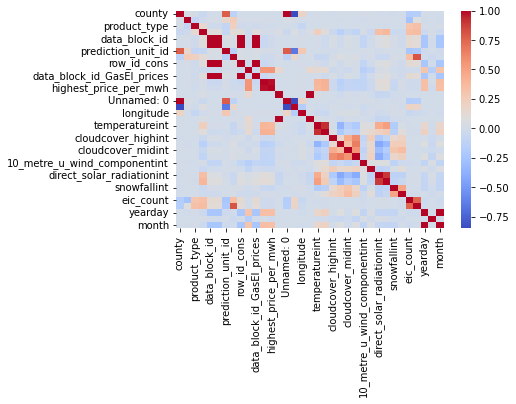

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(corr_matrix, cmap="coolwarm")
#plt.show()

# try to fit a little tree

In [41]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

In [44]:
Y = df[['target_prod','target_cons']]
X = df.drop(['target_prod','target_cons', 'datetime_x',
       'row_id_cons', 'forecast_date', 'origin_date',
       'Unnamed: 0',
       'forecast_datetime', 'hours_ahead', 'origin_datetime', 'datetime_y', 'date'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42, shuffle = False)

In [51]:
y_train.target_cons

1464       0.793
1465       2.106
1466       0.955
1467       0.711
1468       0.729
           ...  
604067    63.683
604068    55.180
604069    50.340
604070    58.049
604071    61.917
Name: target_prod, Length: 601739, dtype: float64

In [52]:
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
random_forest_model.fit(X_train, y_train.target_prod)

ValueError: continuous is not supported

In [54]:
random_forest_test_predictions = random_forest_model.predict(X_train)
random_forest_test_accuracy = sum(abs(y_train.target_prod - random_forest_test_predictions))/len(y_train)
print("Random Forest train Accuracy:", random_forest_test_accuracy)

# Make predictions on the testing set using the trained model
random_forest_test_predictions = random_forest_model.predict(X_test)

# Calculate accuracy of the random forest model on the testing set
random_forest_test_accuracy = sum(abs(y_test.target_prod- random_forest_test_predictions))/len(y_test)
print("Random Forest Test Accuracy:", random_forest_test_accuracy)

Random Forest train Accuracy: 26.07718183200533
Random Forest Test Accuracy: 43.93698269424609


In [55]:
print(random_forest_test_predictions[0:20])
print(y_test.target_prod.to_numpy()[0:20])

[ 16.6031463    5.84723095   0.89005171   0.88896512   0.76900953
   0.76379282   0.76379282   0.7359595    0.26925229   0.26925229
   0.26925229   0.26925229   0.26925229   0.56286539   1.32390281
  10.68224417  60.86747416  71.44241514 234.2327413  218.67328976]
[4.58090e+01 1.90300e+01 5.11700e+00 1.25000e-01 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 1.21900e+00 5.64000e-01 4.70000e-01 7.56000e-01
 6.13000e-01 8.60000e-02 5.00000e-03 8.18000e-01 1.12830e+01 5.91650e+01
 1.59393e+02 2.37765e+02]


In [1]:

for i,feat in enumerate(X.columns):
    print(feat, random_forest_model.feature_importances_[i])

NameError: name 'X' is not defined

In [ ]:
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
random_forest_model.fit(X_train, y_train.target_cons)
random_forest_test_predictions = random_forest_model.predict(X_train)
random_forest_test_accuracy = balanced_accuracy_score(y_train.target_cons, random_forest_test_predictions)
print("Random Forest train Accuracy:", random_forest_test_accuracy)

# Make predictions on the testing set using the trained model
random_forest_test_predictions = random_forest_model.predict(X_test)

# Calculate accuracy of the random forest model on the testing set
random_forest_test_accuracy = balanced_accuracy_score(y_test.target_cons, random_forest_test_predictions)
print("Random Forest Test Accuracy:", random_forest_test_accuracy)
print(random_forest_test_predictions)
#print(y_test.target_cons.to_numpy())

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
scaler2 = MinMaxScaler()
Y_normalized = scaler2.fit_transform(Y)


X_trainN, X_testN, y_trainN, y_testN = train_test_split(X_normalized, Y_normalized, test_size=0.4, random_state=42, shuffle = False)

random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
random_forest_model.fit(X_trainN, y_trainN)
random_forest_test_predictions = random_forest_model.predict(X_trainN)
random_forest_test_accuracy = balanced_accuracy_score(y_trainN, random_forest_test_predictions)
print("Random Forest train Accuracy:", random_forest_test_accuracy)

# Make predictions on the testing set using the trained model
random_forest_test_predictions = random_forest_model.predict(X_testN)

# Calculate accuracy of the random forest model on the testing set
random_forest_test_accuracy = balanced_accuracy_score(y_testN, random_forest_test_predictions)
print("Random Forest Test Accuracy:", random_forest_test_accuracy)
print(random_forest_test_predictions)
print(y_testN.to_numpy())
